# Setup

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data: the Muffins vs Chihuahuas dataset

### Raw data download

import kaggle

dataset_slug = 'samuelcortinhas/muffin-vs-chihuahua-image-classification'
download_path = 'archive'  # Specify the directory where you want to download the dataset

kaggle.api.dataset_download_files(dataset_slug, path=download_path, unzip=True)


### Filter out the corrupted images

In [4]:
import os

num_skipped = 0
for folder_name in ("test\\chihuahua", "train\\chihuahua", "test\\muffin", "train\\muffin"):
    folder_path = os.path.join("archive", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


### Generate a Dataset

In [5]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    'archive/train',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=1337
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'archive/test',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


## Visualize the data

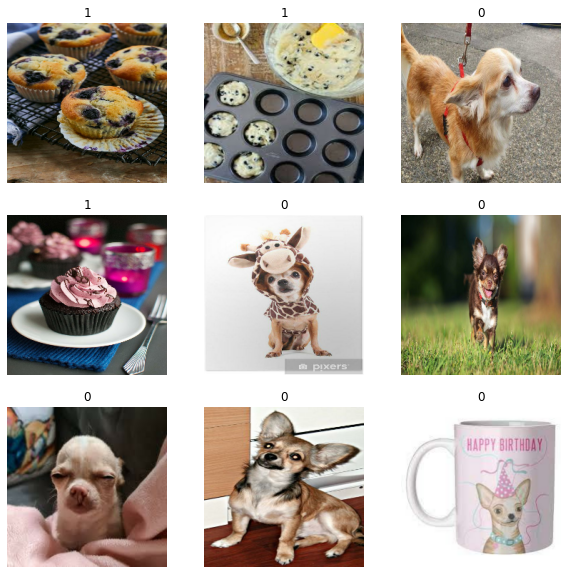

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

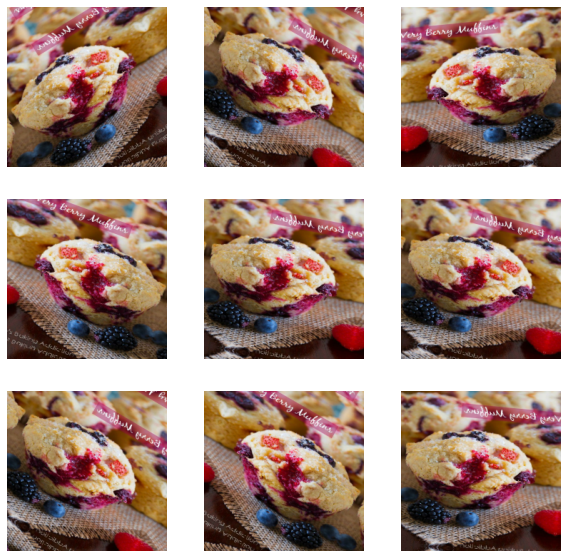

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

In [9]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

## Configure dataset for perfomance

In [10]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Build the model

In [11]:
from tensorflow.keras.utils import plot_model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Train the model

In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Epoch 1/25
148/148 [==============================] - 1221s 8s/step - loss: 0.3866 - accuracy: 0.8390 - val_loss: 0.8366 - val_accuracy: 0.5405
Epoch 2/25
148/148 [==============================] - 1198s 8s/step - loss: 0.2869 - accuracy: 0.8908 - val_loss: 1.3635 - val_accuracy: 0.5405
Epoch 3/25
 58/148 [==========>...................] - ETA: 11:57 - loss: 0.2751 - accuracy: 0.8971

KeyboardInterrupt: 

# Run inference on new data

In [23]:
img = keras.utils.load_img(
    "archive/test/muffin/img_0_67.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")


1/1 [==============================] - 0s 91ms/step
This image is 98.10% chihuahua and 1.90% muffin.


In [29]:
 from tensorflow.python.client import device_lib
 def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
 print(get_available_devices()) 
 # my output was => ['/device:CPU:0']
 # good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0']


In [25]:
tf.test.gpu_device_name()

''